# **Libraries**

In [1]:
import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
from sklearn.model_selection import train_test_split
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
from TransformerBlockClass import LayerNorm, GELU, FeedForward, MultiHeadAttention, TransformerBlock
from All_Functions import text_to_token_ids, token_ids_to_text, calc_loss_batch, calc_loss_loader, evaluate_model, generate, train_model


# **Dataset**

I used [Dataset](https://www.kaggle.com/datasets/thedevastator/tinystories-narrative-classification) from Kaggle, it has over 2M rows of tiny stories so I sampled 5k and saved them local as StroyData then split it to train/validation (4k,1k) and saved them as txt files.

In [3]:
df = pd.read_csv("/content/Story_data.csv")
df.head()

,text
0,"Once upon a time, there was a mighty bird name..."
1,Once upon a time there lived a unique yacht. I...
2,"Once upon a time, in a land full of bright col..."
3,"Once upon a time, there lived a very patient p..."
4,Once upon a time there was a little girl calle...


In [14]:
df['text'][0]

'Once upon a time, there was a mighty bird named Bob. Bob had a best friend named Tim, who was a little mouse. They lived in a big tree with many other animals. One day, Bob and Tim found a long cord hanging from a branch. They did not know what it was for, but they wanted to play with it.\n\nBob said to Tim, "Let\'s pull the cord and see what happens!" Tim was a bit scared but decided to try. They both pulled the cord together. Suddenly, a big box fell from the sky and landed near them. The other animals heard the noise and came to see what was going on.\n\nThe big box had a lock on it, and all the animals tried to open it. They pushed and pulled but could not open it. Tim had an idea and said, "Let\'s use the cord to open the lock!" They tied the cord around the lock and pulled with all their might. The lock broke, and the box opened. Inside the box, there were toys for all the animals to play with. But then, the animals started fighting over the toys. Bob saw this and screamed, "Sto

In [ ]:
df.info()

## Preprocessing

In [4]:
def clean_text(text):

    if pd.isna(text):
        return ""

    text = str(text)
    text = re.sub(r'[^\w\s.,!?]', '', text)  # Keep basic punctuation
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text.strip()

df['clean_story'] = df['text'].apply(clean_text)

In [5]:
print(f"Text before cleaning: {df['text'][0]}\n")
print(f"Text after cleaning: {df['clean_story'][0]}")

Text before cleaning: Once upon a time, there was a mighty bird named Bob. Bob had a best friend named Tim, who was a little mouse. They lived in a big tree with many other animals. One day, Bob and Tim found a long cord hanging from a branch. They did not know what it was for, but they wanted to play with it.

Bob said to Tim, "Let's pull the cord and see what happens!" Tim was a bit scared but decided to try. They both pulled the cord together. Suddenly, a big box fell from the sky and landed near them. The other animals heard the noise and came to see what was going on.

The big box had a lock on it, and all the animals tried to open it. They pushed and pulled but could not open it. Tim had an idea and said, "Let's use the cord to open the lock!" They tied the cord around the lock and pulled with all their might. The lock broke, and the box opened. Inside the box, there were toys for all the animals to play with. But then, the animals started fighting over the toys. Bob saw this and

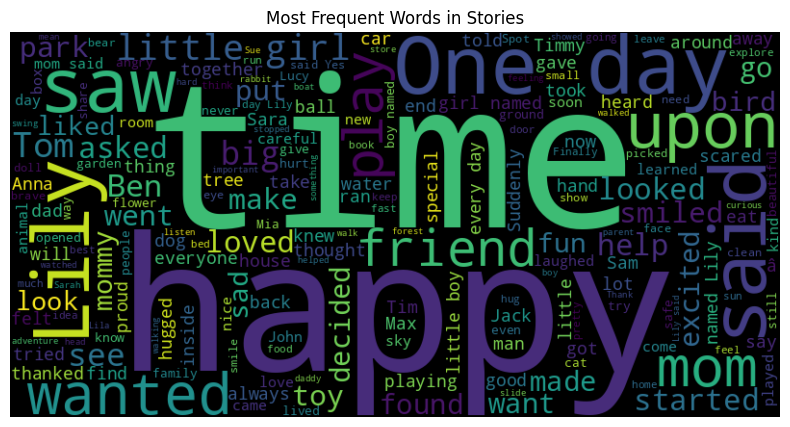

In [6]:
# Combine stories
all_text = ' '.join(df['clean_story'])

# Word Cloud for most frequent words
wordcloud = WordCloud(width=800, height=400).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Stories')
plt.show()

## Spliting Dataset


In [7]:

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) # train (80%), temp (20%)

print(f"Train: {len(train_df)}, Val: {len(val_df)}")

Train: 4000, Val: 1000


# **Data Loader**

In [8]:

tokenizer = tiktoken.get_encoding("gpt2")

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken

# 1. Enhanced Config (Additions in bold)
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.2,
    "qkv_bias": False,
    "bos_token_id": 50256,  # Explicit BOS token
    "eos_token_id": 50256   # EOS = BOS in GPT-2
}


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(path, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    with open(path, "r", encoding = "utf-8") as f:
        txt = f.read()

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [10]:

train_loader = create_dataloader_v1(
    "/content/train_data.txt",
    batch_size=16,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    "/content/valid_data.txt",
    batch_size=16,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)
    print("Sample:", token_ids_to_text(inputs[0], tokenizer)[:50] + "...")
    break

Input shape: torch.Size([16, 256])
Sample: . When she was finished, it was a beautiful castle...


# **Implementing GPT-2 from Scratch**

In [11]:
import torch.nn as nn
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **Training**

In [13]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.1)

num_epochs = 7
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="One day, a little girl named Lily found a needle in her room. She knew...", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Epoch 1/7:
Train Loss: 6.843 | Val Loss: 5.300

Generation after Epoch 1:
One day, a little girl named Lily found a needle in her room. She knew... for a of you her mommy was so proud and the box, Lily and went for the boy

Epoch 2/7:
Train Loss: 5.026 | Val Loss: 4.716

Generation after Epoch 2:
One day, a little girl named Lily found a needle in her room. She knew... around a big tree and wanted to come to play with her mommy was scared and the park and

Epoch 3/7:
Train Loss: 4.617 | Val Loss: 4.457

Generation after Epoch 3:
One day, a little girl named Lily found a needle in her room. She knew... and ran to the door asked it and wanted to take a big, Yes, so excited! So

Epoch 4/7:
Train Loss: 4.392 | Val Loss: 4.298

Generation after Epoch 4:
One day, a little girl named Lily found a needle in her room. She knew..., Lily had to his mommy and wanted to go inside. The boy named Lily felt the bird

Epoch 5/7:
Train Loss: 4.235 | Val Loss: 4.185

Generation after Epoch 5:
One day, a

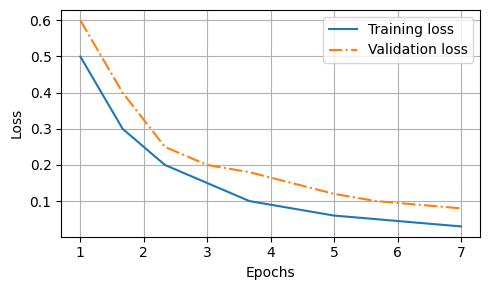

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, train_losses, val_losses):
    plt.figure(figsize=(5, 3))

    # Plot training and validation loss
    plt.plot(epochs_seen, train_losses, label="Training loss")
    plt.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # Force integer ticks on x-axis (epochs)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.grid(True)  # Optional: Add grid for better readability
    plt.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

# Example usage:
import torch

# Assuming:
# - `train_losses` = list of training losses per epoch
# - `val_losses` = list of validation losses per epoch
# - `num_epochs` = total epochs trained

train_losses = [0.5, 0.3, 0.2, 0.15, 0.1, 0.08, 0.06, 0.05, 0.04, 0.03]  # Example
val_losses = [0.6, 0.4, 0.25, 0.2, 0.18, 0.15, 0.12, 0.1, 0.09, 0.08]    # Example

# Generate epochs_seen (if not already available)
epochs_seen = torch.linspace(1, num_epochs, len(train_losses))

plot_losses(epochs_seen, train_losses, val_losses)